In [2]:
import sys
import logging
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
import pickle
import re

In [3]:
coef = pd.read_csv('hoe_coef_ds3.csv')
coef = coef.rename(columns={'Unnamed: 0': "coefficients"})
coef

,coefficients,mean,sd,hdi_3%,hdi_97%
0,g_beta_0[0],-0.248,0.020,-0.287,-0.211
1,g_beta_0[1],0.069,0.046,-0.017,0.156
2,g_beta_0[2],0.093,0.046,0.004,0.176
3,beta_0[1],-0.239,0.037,-0.309,-0.168
4,beta_0[18],-0.248,0.034,-0.313,-0.183
...,...,...,...,...,...
6615,chol_stds[35],0.067,0.029,0.009,0.114
6616,chol_stds[36],0.102,0.025,0.052,0.148
6617,chol_stds[37],0.054,0.023,0.006,0.093
6618,chol_stds[38],0.083,0.018,0.049,0.117


In [4]:
feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']
ridge_coef = pd.read_csv('/Users/wenyuzeng/Downloads/bal_acc_per_assay.csv')
assay_name = ridge_coef.assay.tolist()

In [5]:
coef_ds3 = coef[coef['coefficients'].str.startswith('beta_protocol')].reset_index(drop=True)
coef_ds3

,coefficients,mean,sd,hdi_3%,hdi_97%
0,"beta_protocol[1, beta_0]",-0.224,0.052,-0.326,-0.131
1,"beta_protocol[1, beta_1]",-0.229,0.077,-0.376,-0.093
2,"beta_protocol[1, beta_2]",-0.170,0.049,-0.272,-0.088
3,"beta_protocol[1, beta_3]",0.220,0.050,0.131,0.316
4,"beta_protocol[1, beta_4]",-0.278,0.043,-0.363,-0.195
...,...,...,...,...,...
1995,"beta_protocol[48, beta_35]",-0.148,0.072,-0.280,-0.013
1996,"beta_protocol[48, beta_36]",0.025,0.075,-0.110,0.171
1997,"beta_protocol[48, beta_37]",0.018,0.053,-0.086,0.116
1998,"beta_protocol[48, beta_38]",-0.121,0.063,-0.233,-0.001


In [6]:
coef_ds3.coefficients[0].replace('[', ', ').split(', ')
coef_ds3

,coefficients,mean,sd,hdi_3%,hdi_97%
0,"beta_protocol[1, beta_0]",-0.224,0.052,-0.326,-0.131
1,"beta_protocol[1, beta_1]",-0.229,0.077,-0.376,-0.093
2,"beta_protocol[1, beta_2]",-0.170,0.049,-0.272,-0.088
3,"beta_protocol[1, beta_3]",0.220,0.050,0.131,0.316
4,"beta_protocol[1, beta_4]",-0.278,0.043,-0.363,-0.195
...,...,...,...,...,...
1995,"beta_protocol[48, beta_35]",-0.148,0.072,-0.280,-0.013
1996,"beta_protocol[48, beta_36]",0.025,0.075,-0.110,0.171
1997,"beta_protocol[48, beta_37]",0.018,0.053,-0.086,0.116
1998,"beta_protocol[48, beta_38]",-0.121,0.063,-0.233,-0.001


In [7]:
coef_ds3['coefficients'] = coef_ds3['coefficients'].str.replace('[', ', ')
coef_ds3[['A', 'assay', 'C']] = coef_ds3['coefficients'].str.split(", ",expand=True) 
coef_ds3

,coefficients,mean,sd,hdi_3%,hdi_97%,A,assay,C
0,"beta_protocol, 1, beta_0]",-0.224,0.052,-0.326,-0.131,beta_protocol,1,beta_0]
1,"beta_protocol, 1, beta_1]",-0.229,0.077,-0.376,-0.093,beta_protocol,1,beta_1]
2,"beta_protocol, 1, beta_2]",-0.170,0.049,-0.272,-0.088,beta_protocol,1,beta_2]
3,"beta_protocol, 1, beta_3]",0.220,0.050,0.131,0.316,beta_protocol,1,beta_3]
4,"beta_protocol, 1, beta_4]",-0.278,0.043,-0.363,-0.195,beta_protocol,1,beta_4]
...,...,...,...,...,...,...,...,...
1995,"beta_protocol, 48, beta_35]",-0.148,0.072,-0.280,-0.013,beta_protocol,48,beta_35]
1996,"beta_protocol, 48, beta_36]",0.025,0.075,-0.110,0.171,beta_protocol,48,beta_36]
1997,"beta_protocol, 48, beta_37]",0.018,0.053,-0.086,0.116,beta_protocol,48,beta_37]
1998,"beta_protocol, 48, beta_38]",-0.121,0.063,-0.233,-0.001,beta_protocol,48,beta_38]


In [8]:
coef_ds3.assay = coef_ds3.assay.astype('Int64')
coef_ds3.sort_values(by='assay')

,coefficients,mean,sd,hdi_3%,hdi_97%,A,assay,C
239,"beta_protocol, 0, beta_39]",-0.038,0.038,-0.109,0.030,beta_protocol,0,beta_39]
217,"beta_protocol, 0, beta_17]",-0.134,0.109,-0.323,0.090,beta_protocol,0,beta_17]
216,"beta_protocol, 0, beta_16]",0.520,0.072,0.389,0.656,beta_protocol,0,beta_16]
215,"beta_protocol, 0, beta_15]",-0.191,0.070,-0.317,-0.057,beta_protocol,0,beta_15]
214,"beta_protocol, 0, beta_14]",-0.181,0.065,-0.301,-0.049,beta_protocol,0,beta_14]
...,...,...,...,...,...,...,...,...
1302,"beta_protocol, 49, beta_22]",0.153,0.066,0.028,0.277,beta_protocol,49,beta_22]
1301,"beta_protocol, 49, beta_21]",-0.413,0.105,-0.615,-0.225,beta_protocol,49,beta_21]
1300,"beta_protocol, 49, beta_20]",0.184,0.047,0.100,0.277,beta_protocol,49,beta_20]
1298,"beta_protocol, 49, beta_18]",0.379,0.040,0.301,0.460,beta_protocol,49,beta_18]


In [9]:
coef_assay_list = []
for i in range(50):
    assay_df = coef_ds3[coef_ds3.assay == i].reset_index(drop=True)
    assay_df = assay_df[['mean']]
    assay_df = assay_df.rename(columns={'mean': assay_name[i]})
    coef_assay_list.append(assay_df)

In [10]:
meta_info_coef = coef[coef['coefficients'].str.startswith('g_beta')].reset_index(drop=True)
meta_info_coef = meta_info_coef[meta_info_coef.index % 3 != 0]
meta_info_coef

,coefficients,mean,sd,hdi_3%,hdi_97%
1,g_beta_0[1],0.069,0.046,-0.017,0.156
2,g_beta_0[2],0.093,0.046,0.004,0.176
4,g_beta_1[1],-0.070,0.056,-0.172,0.031
5,g_beta_1[2],0.258,0.054,0.150,0.356
7,g_beta_2[1],-0.019,0.056,-0.123,0.097
...,...,...,...,...,...
113,g_beta_37[2],-0.096,0.051,-0.189,0.004
115,g_beta_38[1],0.002,0.053,-0.095,0.112
116,g_beta_38[2],0.090,0.047,0.004,0.176
118,g_beta_39[1],0.035,0.032,-0.020,0.094


In [11]:
meta_info_coef['coefficients'] = meta_info_coef['coefficients'].str.replace('[', '_')
meta_info_coef['coefficients'] = meta_info_coef['coefficients'].str.replace(']', '_')
meta_info_coef[['A', 'B',"descriptor", 'g_o', 'D']] = meta_info_coef['coefficients'].str.split("_",expand=True)
meta_info_coef

,coefficients,mean,sd,hdi_3%,hdi_97%,A,B,descriptor,g_o,D
1,g_beta_0_1_,0.069,0.046,-0.017,0.156,g,beta,0,1,
2,g_beta_0_2_,0.093,0.046,0.004,0.176,g,beta,0,2,
4,g_beta_1_1_,-0.070,0.056,-0.172,0.031,g,beta,1,1,
5,g_beta_1_2_,0.258,0.054,0.150,0.356,g,beta,1,2,
7,g_beta_2_1_,-0.019,0.056,-0.123,0.097,g,beta,2,1,
...,...,...,...,...,...,...,...,...,...,...
113,g_beta_37_2_,-0.096,0.051,-0.189,0.004,g,beta,37,2,
115,g_beta_38_1_,0.002,0.053,-0.095,0.112,g,beta,38,1,
116,g_beta_38_2_,0.090,0.047,0.004,0.176,g,beta,38,2,
118,g_beta_39_1_,0.035,0.032,-0.020,0.094,g,beta,39,1,


In [12]:
meta_info_coef_mean = meta_info_coef.iloc[:, [0,1,8]].reset_index(drop=True)
meta_info_coef_mean = meta_info_coef_mean.astype({'g_o': 'int32'})

In [13]:
gender_organism = meta_info_coef_mean.groupby(['g_o'], as_index=False).agg({'mean':['mean','std']})
gender_organism.columns = gender_organism.columns.get_level_values(0)
gender_organism.columns = ['Features','mean_val', 'std_val']
gender_organism.Features = ['Organism', 'Gender']
gender_organism

,Features,mean_val,std_val
0,Organism,-0.010275,0.100770
1,Gender,-0.000325,0.139169


In [14]:
mean_df = pd.concat(coef_assay_list, axis=1)
mean_df['Features'] = feature_top_40
mean_df = mean_df.set_index('Features')
mean_df

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-sbe-bla-antagonist-p1,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1,tox21-dt40-p1_653,tox21-dt40-p1_100,tox21-dt40-p1_657,tox21-rt-viability-hepg2-p1,tox21-rt-viability-hek293-p1
Features,,,,,,,,,,,,,,,,,,,,,
fr_C_O,-0.156,-0.224,-0.233,-0.239,-0.266,-0.249,-0.213,-0.296,-0.172,-0.151,...,-0.165,-0.241,-0.110,-0.260,-0.237,-0.238,-0.122,-0.129,-0.216,-0.245
TPSA,-0.318,-0.229,-0.205,-0.282,-0.212,-0.292,-0.366,-0.230,-0.271,-0.312,...,-0.172,0.040,-0.347,-0.200,-0.245,-0.246,-0.115,-0.128,-0.277,-0.183
SMR_VSA1,-0.172,-0.170,-0.147,-0.171,-0.161,-0.181,-0.184,-0.164,-0.178,-0.171,...,-0.086,-0.142,-0.181,-0.126,-0.170,-0.167,-0.087,-0.110,-0.170,-0.147
NumHAcceptors,0.170,0.220,0.185,0.170,0.175,0.204,0.185,0.191,0.171,0.166,...,0.147,0.177,0.165,0.207,0.212,0.209,0.121,0.109,0.201,0.206
NumAromaticCarbocycles,-0.229,-0.278,-0.269,-0.272,-0.268,-0.274,-0.252,-0.268,-0.229,-0.242,...,-0.152,-0.265,-0.253,-0.243,-0.298,-0.297,-0.120,-0.110,-0.276,-0.263
NumHeteroatoms,-0.158,-0.278,-0.236,-0.194,-0.199,-0.298,-0.233,-0.180,-0.310,-0.171,...,-0.217,-0.163,-0.223,-0.214,-0.311,-0.281,-0.193,-0.195,-0.216,-0.196
Chi4n,-0.275,-0.332,-0.320,-0.280,-0.275,-0.234,-0.191,-0.278,-0.237,-0.236,...,-0.117,-0.303,-0.036,-0.326,-0.268,-0.207,-0.103,-0.108,-0.296,-0.304
VSA_EState10,0.070,0.067,0.079,0.066,0.070,0.168,0.193,0.090,0.092,0.115,...,0.005,-0.035,0.275,0.046,0.174,0.111,-0.060,-0.076,0.134,0.067
VSA_EState3,-0.362,-0.362,-0.379,-0.371,-0.388,-0.388,-0.380,-0.339,-0.392,-0.384,...,-0.197,-0.363,-0.424,-0.365,-0.414,-0.406,-0.187,-0.177,-0.363,-0.367


In [15]:
assay_info = pd.read_csv('/Users/wenyuzeng/Downloads/assay_info.csv')
assay_info = assay_info.rename(columns = {'ProtocolName':'assay'})
assay_info

,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism,Tissue_Type2,assay
0,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-agonist-p3
1,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-antagonist-p1
2,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-antagonist-p2
3,MCF-7,Primary,epithelial,F,Human,mammary gland,tox21-aromatase-p1
4,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_100
5,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_653
6,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_657
7,NIH/3T3,Normal,fibroblast,M,Animal cell,connective tissue,tox21-shh-3t3-gli3-agonist-p1
8,NIH/3T3,Normal,fibroblast,M,Animal cell,connective tissue,tox21-shh-3t3-gli3-antagonist-p1
9,C3H10T1/2,Normal,fibroblast,F,Animal cell,connective tissue,tox21-rar-antagonist-p2


In [16]:
new_ridge_coef = ridge_coef.merge(assay_info, on='assay')
new_ridge_coef

,assay,number_of_compound,number_of_active,number_of_inactive,0,1,2,3,4,Organism_x,mean_bal_acc,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism_y,Tissue_Type2
0,tox21-ahr-p1,7674,615,7059,0.752015,0.735115,0.747602,0.760323,0.751365,Human,0.749284,HepG2,Primary,epithelial-like,M,Human,liver
1,tox21-ap1-agonist-p1,7394,393,7001,0.702074,0.714258,0.718092,0.739258,0.745752,Human,0.723887,ME-180,Metastatic,epithelial,F,Human,omentum
2,tox21-ar-bla-antagonist-p1,7568,743,6825,0.700561,0.709375,0.701632,0.743201,0.705735,Human,0.712101,HEK293,Normal,epithelial,F,Human,kidney
3,tox21-ar-mda-kb2-luc-agonist-p3,7379,830,6549,0.757046,0.718890,0.721620,0.731949,0.750465,Human,0.735994,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion
4,tox21-ar-mda-kb2-luc-antagonist-p1,7823,637,7186,0.741278,0.755181,0.759861,0.752917,0.716597,Human,0.745167,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion
5,tox21-ar-mda-kb2-luc-antagonist-p2,7554,554,7000,0.779479,0.756368,0.779833,0.774440,0.759557,Human,0.769936,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion
6,tox21-are-bla-p1,6958,548,6410,0.757489,0.751260,0.755544,0.779308,0.762170,Human,0.761154,HepG2,Primary,epithelial-like,M,Human,liver
7,tox21-aromatase-p1,7614,884,6730,0.737618,0.727042,0.736410,0.722507,0.729613,Human,0.730638,MCF-7,Primary,epithelial,F,Human,mammary gland
8,tox21-car-agonist-p1,7389,684,6705,0.747363,0.738933,0.753054,0.752098,0.746658,Human,0.747621,HepG2,Primary,epithelial-like,M,Human,liver
9,tox21-car-antagonist-p1,7424,745,6679,0.739930,0.721583,0.721213,0.738668,0.712979,Human,0.726875,HepG2,Primary,epithelial-like,M,Human,liver


In [28]:
from matplotlib.patches import Patch
lut = dict(zip(new_ridge_coef.Organism_x.unique(), ["#298c8c", "#800074"]))
lut2 = dict(zip(new_ridge_coef.Gender.unique(), ["#999999", '#ffbb6f']))
# sample_cols = dict(zip(set(samples), ))["purple", "yellow"

col_colors = pd.DataFrame({'Organism':new_ridge_coef.Organism_x.map(lut),
                          'Sex':new_ridge_coef.Gender.map(lut2), 
                          'assay':new_ridge_coef.assay}).set_index('assay')
# color_df = pd.DataFrame({"type": color_pal, "size": color_th}, index=data.columns)

<Figure size 3000x3000 with 0 Axes>

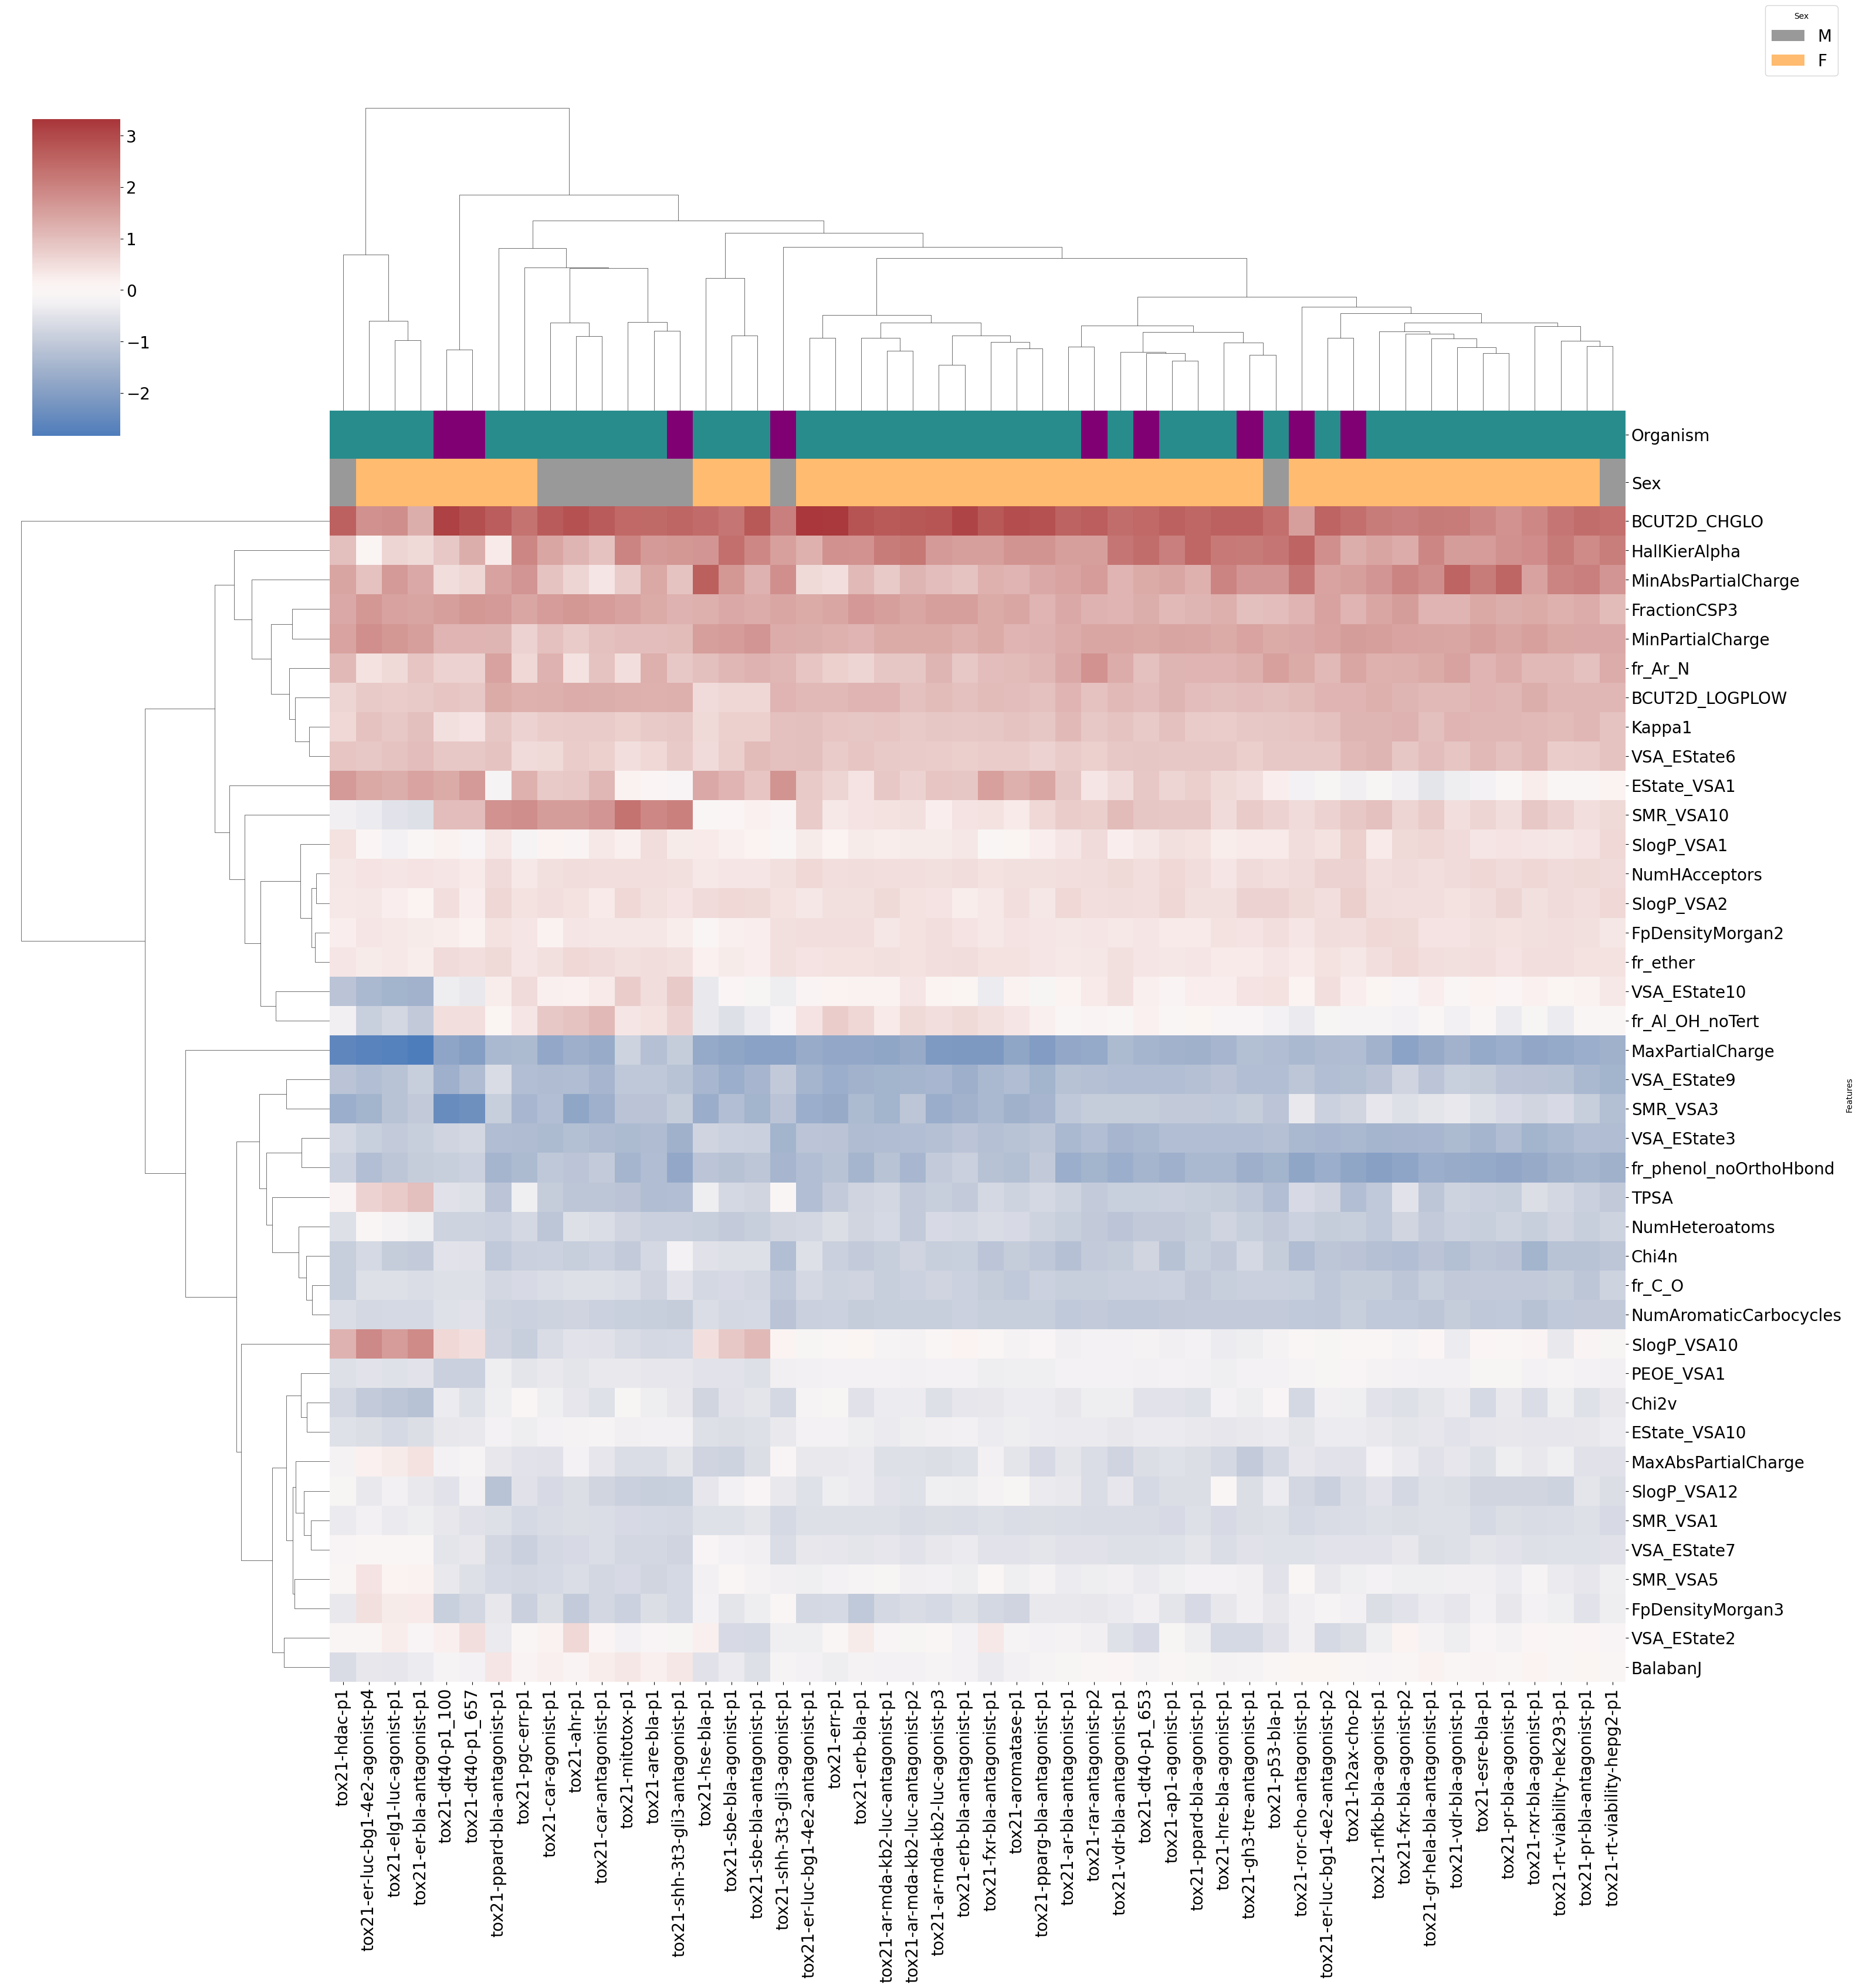

In [29]:
fig = plt.figure(figsize = (30,30))
sns.set_color_codes('pastel')
# ax = sns.heatmap(fea_df.set_index('features'), cmap='vlag')
ax = sns.clustermap(mean_df, cmap = 'vlag', z_score = 1, center=0, figsize=(30, 30), col_colors=col_colors)
# ax.axes.set_title('Assay by Features heatmap',fontsize=30)
# ax.set_xlabel("Assays",fontsize=20)
# ax.set_ylabel("Features",fontsize=20)
ax.tick_params(labelsize=20)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)
handles = [Patch(facecolor=lut[name]) for name in lut]
handles2 = [Patch(facecolor=lut2[name2]) for name2 in lut2]

lg1 = plt.legend(handles, lut, title='Organisms',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right', fontsize=20)
lg2 = plt.legend(handles2, lut2, title='Sex',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc=3, fontsize=20)
plt.savefig('Feature_importance_HBM_ds3.tiff', bbox_inches="tight")
plt.show()

### Horizontal Barplot

In [24]:
# mean_df_abs = abs(mean_df)
mean_df_abs = mean_df.copy(deep=True)
mean_df_abs['mean_val'] = np.mean(mean_df_abs,axis=1)
mean_df_abs['std_val'] = np.std(mean_df_abs.iloc[:,:-1], axis=1)
mean_df_abs

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1,tox21-dt40-p1_653,tox21-dt40-p1_100,tox21-dt40-p1_657,tox21-rt-viability-hepg2-p1,tox21-rt-viability-hek293-p1,mean_val,std_val
Features,,,,,,,,,,,,,,,,,,,,,
fr_C_O,-0.156,-0.224,-0.233,-0.239,-0.266,-0.249,-0.213,-0.296,-0.172,-0.151,...,-0.110,-0.260,-0.237,-0.238,-0.122,-0.129,-0.216,-0.245,-0.21716,0.053815
TPSA,-0.318,-0.229,-0.205,-0.282,-0.212,-0.292,-0.366,-0.230,-0.271,-0.312,...,-0.347,-0.200,-0.245,-0.246,-0.115,-0.128,-0.277,-0.183,-0.20150,0.142536
SMR_VSA1,-0.172,-0.170,-0.147,-0.171,-0.161,-0.181,-0.184,-0.164,-0.178,-0.171,...,-0.181,-0.126,-0.170,-0.167,-0.087,-0.110,-0.170,-0.147,-0.14468,0.037390
NumHAcceptors,0.170,0.220,0.185,0.170,0.175,0.204,0.185,0.191,0.171,0.166,...,0.165,0.207,0.212,0.209,0.121,0.109,0.201,0.206,0.18280,0.031387
NumAromaticCarbocycles,-0.229,-0.278,-0.269,-0.272,-0.268,-0.274,-0.252,-0.268,-0.229,-0.242,...,-0.253,-0.243,-0.298,-0.297,-0.120,-0.110,-0.276,-0.263,-0.24156,0.053243
NumHeteroatoms,-0.158,-0.278,-0.236,-0.194,-0.199,-0.298,-0.233,-0.180,-0.310,-0.171,...,-0.223,-0.214,-0.311,-0.281,-0.193,-0.195,-0.216,-0.196,-0.21162,0.066244
Chi4n,-0.275,-0.332,-0.320,-0.280,-0.275,-0.234,-0.191,-0.278,-0.237,-0.236,...,-0.036,-0.326,-0.268,-0.207,-0.103,-0.108,-0.296,-0.304,-0.25028,0.073142
VSA_EState10,0.070,0.067,0.079,0.066,0.070,0.168,0.193,0.090,0.092,0.115,...,0.275,0.046,0.174,0.111,-0.060,-0.076,0.134,0.067,0.05484,0.127202
VSA_EState3,-0.362,-0.362,-0.379,-0.371,-0.388,-0.388,-0.380,-0.339,-0.392,-0.384,...,-0.424,-0.365,-0.414,-0.406,-0.187,-0.177,-0.363,-0.367,-0.33826,0.074537


In [25]:
h_coe = mean_df_abs.sort_values(by=['mean_val'], ascending=True).iloc[:,-2:].reset_index()
h_coe = pd.concat([h_coe, gender_organism]).sort_values(by=['mean_val'], ascending=True).reset_index(drop=True)
h_coe = h_coe.set_index('Features')

In [26]:
categories = []
for i in h_coe.index:
    if i.startswith('fr_'):
        categories.append('Fraction of a substructure')
    elif i.startswith('PEOE'):
        categories.append('MOE type - Partial Charges')
    elif i.startswith('SlogP'):
        categories.append('MOE type - LogP')
    elif i.startswith('SMR'):
        categories.append('MOE type - MR')
    elif i.startswith('EState') or i.startswith('VSA'):
        categories.append('MOE type - EState')
    elif i.startswith('BCUT2D'):
        categories.append('BCUT type')
    elif i.startswith('Gender') or i.startswith('Organism'):
        categories.append('assay_meta_info')
    else:
        categories.append('physicochemical properties')
h_coe['category'] = categories
h_coe

,mean_val,std_val,category
Features,,,
MaxPartialCharge,-0.474860,0.100345,physicochemical properties
fr_phenol_noOrthoHbond,-0.379460,0.090983,Fraction of a substructure
VSA_EState9,-0.344860,0.084248,MOE type - EState
VSA_EState3,-0.338260,0.074537,MOE type - EState
SMR_VSA3,-0.318020,0.139760,MOE type - MR
Chi4n,-0.250280,0.073142,physicochemical properties
NumAromaticCarbocycles,-0.241560,0.053243,physicochemical properties
fr_C_O,-0.217160,0.053815,Fraction of a substructure
NumHeteroatoms,-0.211620,0.066244,physicochemical properties


In [30]:
h_coe = h_coe.rename(index={'Gender': 'Sex'})

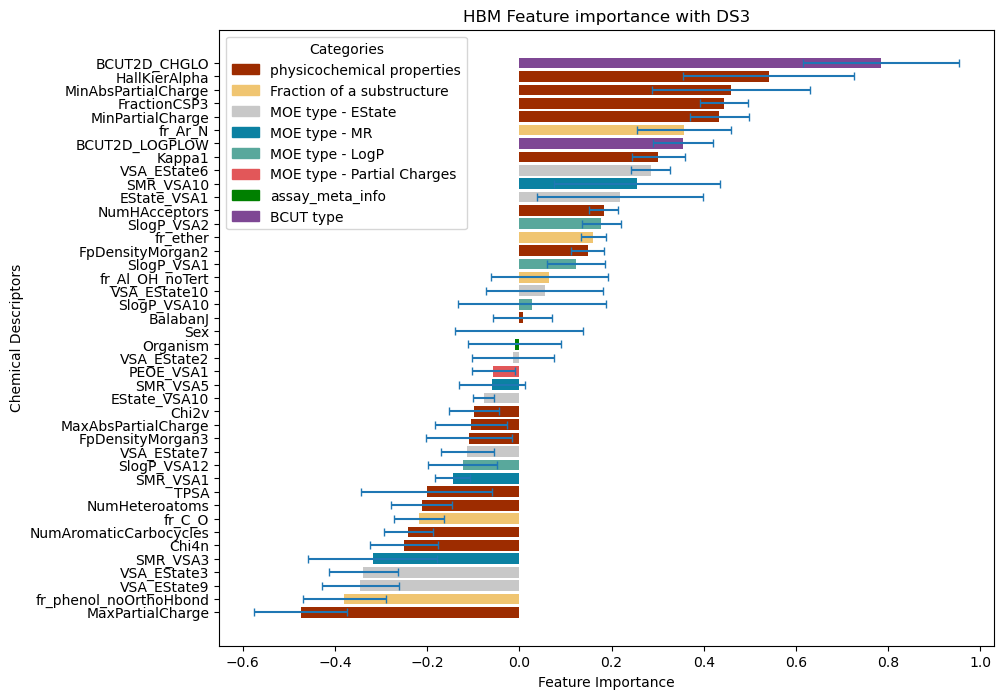

In [31]:
h_coe_plot = h_coe.reset_index()
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': '#c8c8c8', 'Fraction of a substructure': '#f0c571', 'MOE type - LogP': '#59a89c',
          'MOE type - MR':'#0b81a2', 'MOE type - Partial Charges': '#e25759',
          'physicochemical properties': '#9d2c00', 'BCUT type': '#7E4794', 'assay_meta_info': 'green'}
plt.barh(data = h_coe_plot, y='Features', width='mean_val', color=[colors[i] for i in h_coe_plot.category])
plt.errorbar(data = h_coe_plot, y='Features', x='mean_val', xerr = 'std_val', fmt ='none', capsize=3)

labels = h_coe['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('HBM Feature importance with DS3')
plt.xlabel('Feature Importance')
plt.ylabel('Chemical Descriptors')
plt.savefig('Feature_importance_HBM_DS3_abs_val(1).tiff', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
h_coe.to_csv('Feature_imp_HBM_DS3.csv')